<a href="https://colab.research.google.com/github/ahdelrawy/3D-segmentation/blob/main/liver_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/3d-liver-and-liver-tumor-segmentation")

print("Path to dataset files:", path)

100%|██████████| 2.16G/2.16G [00:26<00:00, 88.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2


In [2]:
# 1. - ثبت الحزم الأساسية
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q albumentations opencv-python-headless nibabel SimpleITK scikit-image plotly pyvista ipywidgets

# 2. - (اختياري) تابع حالة torch في الـ Colab
import torch
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
Torch: 2.8.0+cu126 CUDA available: True


In [3]:
import os

for root, dirs, files in os.walk("/content/data"):
    for f in files:
        print(os.path.join(root, f))


In [4]:
import kagglehub

# نزّل الداتا
path = kagglehub.dataset_download("gauravduttakiit/3d-liver-and-liver-tumor-segmentation")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2


In [5]:
import os

data_path = "/kaggle/input/3d-liver-and-liver-tumor-segmentation"

for root, dirs, files in os.walk(data_path):
    for f in files:
        print(os.path.join(root, f))


In [6]:
import os

data_path = "/kaggle/input/3d-liver-and-liver-tumor-segmentation/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs"

for root, dirs, files in os.walk(data_path):
    if "images" in root.lower():
        print("📷 Images folder:", root)
        for f in files[:5]:  # أول 5 ملفات بس
            print("   ", f)
    if "labels" in root.lower():
        print("🟢 Labels folder:", root)
        for f in files[:5]:
            print("   ", f)


In [7]:
import os

print("Dataset root path:", path)
print("Subfolders inside:")
print(os.listdir(path))


Dataset root path: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2
Subfolders inside:
['08-3D-Liver-Tumor-Segmentation']


In [8]:
images_path = "/root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/images"
labels_path = "/root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labels"

import os
print("Images:", os.listdir(images_path)[:5])
print("Labels:", os.listdir(labels_path)[:5])


Images: ['liver_129.nii', 'liver_50.nii', 'liver_58.nii', 'liver_115.nii', 'liver_49.nii']
Labels: ['liver_129.nii', 'liver_50.nii', 'liver_58.nii', 'liver_115.nii', 'liver_49.nii']


In [10]:
import os

def find_subfolder(root, name):
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath) == name:
            return dirpath
    return None

images_path = find_subfolder(path, "images")
labels_path = find_subfolder(path, "labels")

print("Images path:", images_path)
print("Labels path:", labels_path)


Images path: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/images
Labels path: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2/08-3D-Liver-Tumor-Segmentation/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labels


Image shape: (232, 232, 200)
Mask shape: (232, 232, 200)


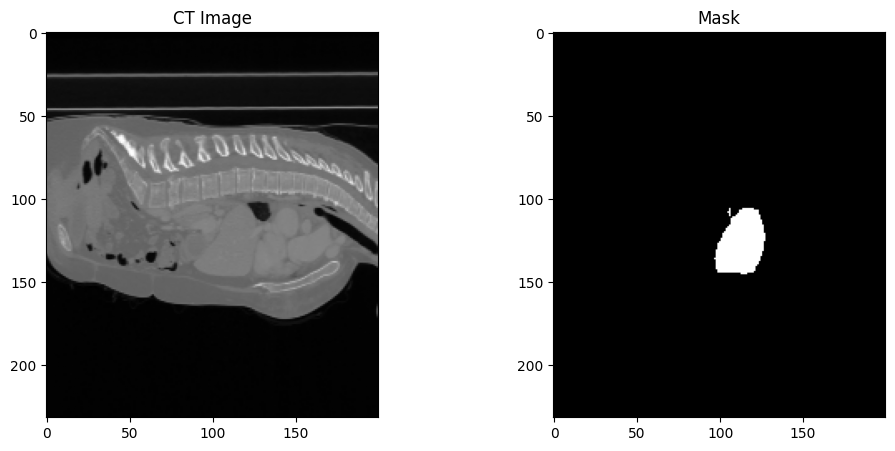

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt

img_file = os.path.join(images_path, "liver_50.nii")
mask_file = os.path.join(labels_path, "liver_50.nii")

img = nib.load(img_file).get_fdata()
mask = nib.load(mask_file).get_fdata()

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

slice_idx = img.shape[0] // 2  # سلايس في النص

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap="gray")
plt.title("CT Image")

plt.subplot(1,2,2)
plt.imshow(mask[slice_idx], cmap="gray")
plt.title("Mask")
plt.show()


In [12]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2

class LiverDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, size=128):
        self.images = sorted(os.listdir(images_dir))
        self.labels = sorted(os.listdir(labels_dir))
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.labels_dir, self.labels[idx])

        img = nib.load(img_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # ناخد مقطع واحد (مثلاً النص) - ممكن بعدين ناخد أكتر
        slice_idx = img.shape[0] // 2
        img = img[slice_idx]
        mask = mask[slice_idx]

        # resize
        img = cv2.resize(img, (self.size, self.size))
        mask = cv2.resize(mask, (self.size, self.size))

        # normalize
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        img = np.expand_dims(img, axis=0)  # (1,H,W)
        mask = np.expand_dims(mask, axis=0)  # (1,H,W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [13]:
from torch.utils.data import DataLoader

dataset = LiverDataset(images_path, labels_path, size=128)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

img_batch, mask_batch = next(iter(loader))
print("Image batch shape:", img_batch.shape)
print("Mask batch shape:", mask_batch.shape)



Image batch shape: torch.Size([2, 1, 128, 128])
Mask batch shape: torch.Size([2, 1, 128, 128])


In [14]:
!pip install -q segmentation-models-pytorch


In [17]:
import segmentation_models_pytorch as smp

# U-Net مع backbone pre-trained
model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # pretraining
    in_channels=1,                  # صور CT channel واحد (مش RGB)
    classes=1,                      # binary segmentation (liver / not liver)
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [16]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.7 MB/s eta 0:00:00


In [20]:
import torch

def dice_score(preds, targets, smooth=1e-6):
    # preds و targets binary tensors (0 أو 1)
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1e-6):
    # preds و targets binary tensors (0 أو 1)
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# مثال على استخدامهم
outputs = torch.randn(2, 1, 128, 128)  # logits من الموديل
masks = torch.randint(0, 2, (2, 1, 128, 128))  # ground truth

preds = torch.sigmoid(outputs) > 0.5  # تحويل logits لـ binary

dice = dice_score(preds, masks)
iou = iou_score(preds, masks)

print("Dice:", dice.item())
print("IoU:", iou.item())


Dice: 0.5023037195205688
IoU: 0.3353842496871948


In [22]:
import torch
import numpy as np

def normalize_image(image):
    # image: numpy array
    image = image.astype(np.float32)
    image = image / 255.0
    return image


In [23]:
import cv2

def resize_image_mask(image, mask, size=(128,128)):
    image_resized = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return image_resized, mask_resized


In [24]:
def to_tensor(image, mask):
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # shape: 1,H,W
    mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)   # shape: 1,H,W
    return image, mask


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os

# ---- Dataset class ----
class LiverDataset(Dataset):
    def __init__(self, images_paths, masks_paths, img_size=(128,128), transform=None):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        # تحميل الصورة والـ mask
        image = cv2.imread(self.images_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.masks_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Resize
        image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize image
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)  # binary mask

        # تحويل لـ tensor
        image = torch.tensor(image).unsqueeze(0)  # shape: 1,H,W
        mask = torch.tensor(mask).unsqueeze(0)    # shape: 1,H,W

        # لو في augmentation
        if self.transform:
            # transform يتعامل مع numpy arrays، لازم ترجعه tensors بعدين
            augmented = self.transform(image=image.numpy(), mask=mask.numpy())
            image = torch.tensor(augmented['image']).unsqueeze(0)
            mask = torch.tensor(augmented['mask']).unsqueeze(0)

        return image, mask


In [26]:
import os

!ls liver_data


ls: cannot access 'liver_data': No such file or directory


In [27]:
import os

data_folder = path  # path ده اللي رجعه kagglehub.dataset_download

# لو الملفات موجودة داخل مجلد فرعي داخل هذا المجلد
for root, dirs, files in os.walk(data_folder):
    print("Root:", root)
    print("Dirs:", dirs)
    print("عدد الملفات:", len(files))
    break  # نطبع أول مجلد فقط عشان نشوف البنية


Root: /root/.cache/kagglehub/datasets/gauravduttakiit/3d-liver-and-liver-tumor-segmentation/versions/2
Dirs: ['08-3D-Liver-Tumor-Segmentation']
عدد الملفات: 0


In [28]:
import os

data_folder = os.path.join(path, "08-3D-Liver-Tumor-Segmentation")

all_files = os.listdir(data_folder)
print("عدد الملفات الكلي:", len(all_files))
print(all_files)


عدد الملفات الكلي: 1
['08-3D-Liver-Tumor-Segmentation']


In [29]:
sub_folder = os.path.join(data_folder, "08-3D-Liver-Tumor-Segmentation")
all_files = os.listdir(sub_folder)
print("عدد الملفات داخل المجلد الفرعي:", len(all_files))
print(all_files)


عدد الملفات داخل المجلد الفرعي: 1
['Task03_Liver_rs']


In [30]:
sub_sub_folder = os.path.join(sub_folder, "Task03_Liver_rs")
all_files = os.listdir(sub_sub_folder)
print("عدد الملفات في Task03_Liver_rs:", len(all_files))
print(all_files)


عدد الملفات في Task03_Liver_rs: 2
['labels', 'images']


In [31]:
images_folder = os.path.join(sub_sub_folder, "images")
masks_folder  = os.path.join(sub_sub_folder, "labels")

# جمع كل ملفات الصور والماسكات
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(".nii.gz")])
mask_files  = sorted([os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith(".nii.gz")])

print("عدد الصور:", len(image_files))
print("عدد الماسكات:", len(mask_files))


عدد الصور: 0
عدد الماسكات: 0


In [32]:
import os

images_folder = os.path.join(sub_sub_folder, "images")
masks_folder  = os.path.join(sub_sub_folder, "labels")

print("ملفات الصور:")
print(os.listdir(images_folder))

print("\nملفات الماسكات:")
print(os.listdir(masks_folder))


ملفات الصور:
['liver_129.nii', 'liver_50.nii', 'liver_58.nii', 'liver_115.nii', 'liver_49.nii', 'liver_36.nii', 'liver_40.nii', 'liver_89.nii', 'liver_113.nii', 'liver_84.nii', 'liver_93.nii', 'liver_8.nii', 'liver_70.nii', 'liver_21.nii', 'liver_80.nii', 'liver_18.nii', 'liver_120.nii', 'liver_35.nii', 'liver_43.nii', 'liver_53.nii', 'liver_116.nii', 'liver_42.nii', 'liver_102.nii', 'liver_4.nii', 'liver_125.nii', 'liver_17.nii', 'liver_123.nii', 'liver_81.nii', 'liver_19.nii', 'liver_16.nii', 'liver_79.nii', 'liver_77.nii', 'liver_76.nii', 'liver_3.nii', 'liver_38.nii', 'liver_54.nii', 'liver_122.nii', 'liver_22.nii', 'liver_99.nii', 'liver_26.nii', 'liver_74.nii', 'liver_94.nii', 'liver_98.nii', 'liver_6.nii', 'liver_73.nii', 'liver_128.nii', 'liver_9.nii', 'liver_57.nii', 'liver_34.nii', 'liver_23.nii', 'liver_7.nii', 'liver_52.nii', 'liver_0.nii', 'liver_92.nii', 'liver_105.nii', 'liver_37.nii', 'liver_64.nii', 'liver_69.nii', 'liver_5.nii', 'liver_41.nii', 'liver_61.nii', 'liver_

In [33]:
import os

images_folder = os.path.join(sub_sub_folder, "images")
masks_folder  = os.path.join(sub_sub_folder, "labels")

# جميع الملفات بصيغة .nii
image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(".nii")])
mask_files  = sorted([os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith(".nii")])

print("عدد الصور:", len(image_files))
print("عدد الماسكات:", len(mask_files))

# التأكد من التطابق
for i in range(5):
    print("Image:", os.path.basename(image_files[i]), "| Mask:", os.path.basename(mask_files[i]))


عدد الصور: 123
عدد الماسكات: 123
Image: liver_0.nii | Mask: liver_0.nii
Image: liver_1.nii | Mask: liver_1.nii
Image: liver_10.nii | Mask: liver_10.nii
Image: liver_101.nii | Mask: liver_101.nii
Image: liver_102.nii | Mask: liver_102.nii


In [34]:
import nibabel as nib
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2

class LiverSliceDataset(Dataset):
    def __init__(self, image_files, mask_files, img_size=(128,128), transform=None):
        self.slices = []
        self.masks  = []
        self.img_size = img_size
        self.transform = transform

        # تحويل كل 3D volume إلى slices 2D
        for img_path, mask_path in zip(image_files, mask_files):
            img_nii = nib.load(img_path)
            mask_nii = nib.load(mask_path)

            img_array = img_nii.get_fdata()
            mask_array = mask_nii.get_fdata()

            # بعض الماسكات ممكن فيها قيم غير 0/1 → نعمل binary
            mask_array = (mask_array > 0).astype(np.float32)

            # تجزئة كل slice من ال volume
            for i in range(img_array.shape[2]):  # غالبًا axis 2 = slices
                slice_img = img_array[:,:,i]
                slice_mask = mask_array[:,:,i]

                # Resize
                slice_img = cv2.resize(slice_img, self.img_size, interpolation=cv2.INTER_LINEAR)
                slice_mask = cv2.resize(slice_mask, self.img_size, interpolation=cv2.INTER_NEAREST)

                # Normalize
                slice_img = slice_img.astype(np.float32) / np.max(slice_img)

                self.slices.append(slice_img)
                self.masks.append(slice_mask)

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        image = torch.tensor(self.slices[idx]).unsqueeze(0)  # shape: 1,H,W
        mask  = torch.tensor(self.masks[idx]).unsqueeze(0)   # shape: 1,H,W

        # لو في augmentation
        if self.transform:
            augmented = self.transform(image=image.numpy(), mask=mask.numpy())
            image = torch.tensor(augmented['image']).unsqueeze(0)
            mask  = torch.tensor(augmented['mask']).unsqueeze(0)

        return image, mask


In [35]:
from torch.utils.data import DataLoader

dataset = LiverSliceDataset(image_files, mask_files, img_size=(128,128))
loader = DataLoader(dataset, batch_size=2, shuffle=True)

print("عدد كل ال slices:", len(dataset))


/tmp/ipython-input-3260747674.py:35: RuntimeWarning: invalid value encountered in divide
  slice_img = slice_img.astype(np.float32) / np.max(slice_img)


عدد كل ال slices: 19604


In [36]:
def __getitem__(self, idx):
    image = torch.tensor(self.slices[idx]).unsqueeze(0)  # shape: 1,H,W
    mask  = torch.tensor(self.masks[idx]).unsqueeze(0)   # shape: 1,H,W

    # لو في augmentation
    if self.transform:
        augmented = self.transform(image=image.numpy(), mask=mask.numpy())
        image = torch.tensor(augmented['image']).unsqueeze(0)
        mask  = torch.tensor(augmented['mask']).unsqueeze(0)

    return image, mask


In [37]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2

class LiverSliceDataset(Dataset):
    def __init__(self, image_files, mask_files, img_size=(128,128), transform=None):
        self.slices = []
        self.masks  = []
        self.img_size = img_size
        self.transform = transform

        # تحويل كل 3D volume إلى slices 2D
        for img_path, mask_path in zip(image_files, mask_files):
            img_nii = nib.load(img_path)
            mask_nii = nib.load(mask_path)

            img_array = img_nii.get_fdata()
            mask_array = mask_nii.get_fdata()

            # تحويل الماسك إلى binary
            mask_array = (mask_array > 0).astype(np.float32)

            # تجزئة كل slice من ال volume
            for i in range(img_array.shape[2]):  # غالبًا axis 2 = slices
                slice_img = img_array[:,:,i]
                slice_mask = mask_array[:,:,i]

                # Resize
                slice_img = cv2.resize(slice_img, self.img_size, interpolation=cv2.INTER_LINEAR)
                slice_mask = cv2.resize(slice_mask, self.img_size, interpolation=cv2.INTER_NEAREST)

                # Normalize مع تجنب القسمة على صفر
                max_val = np.max(slice_img)
                if max_val > 0:
                    slice_img = slice_img.astype(np.float32) / max_val
                else:
                    slice_img = slice_img.astype(np.float32)

                self.slices.append(slice_img)
                self.masks.append(slice_mask)

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        image = torch.tensor(self.slices[idx]).unsqueeze(0)  # shape: 1,H,W
        mask  = torch.tensor(self.masks[idx]).unsqueeze(0)   # shape: 1,H,W

        # لو في augmentation
        if self.transform:
            augmented = self.transform(image=image.numpy(), mask=mask.numpy())
            image = torch.tensor(augmented['image']).unsqueeze(0)
            mask  = torch.tensor(augmented['mask']).unsqueeze(0)

        return image, mask


# ======== استخدام الـ Dataset ========

images_folder = os.path.join(sub_sub_folder, "images")
masks_folder  = os.path.join(sub_sub_folder, "labels")

image_files = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith(".nii")])
mask_files  = sorted([os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith(".nii")])

dataset = LiverSliceDataset(image_files, mask_files, img_size=(128,128))
print("عدد كل ال slices:", len(dataset))

# تجربة أول slice
image, mask = dataset[0]
print("شكل الصورة:", image.shape)
print("شكل الماسك:", mask.shape)

# إنشاء DataLoader
loader = DataLoader(dataset, batch_size=2, shuffle=True)


عدد كل ال slices: 19604
شكل الصورة: torch.Size([1, 128, 128])
شكل الماسك: torch.Size([1, 128, 128])


In [38]:
!pip install segmentation-models-pytorch --quiet

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp


In [39]:
model = smp.Unet(
    encoder_name="resnet34",        # backbone مُسبق التدريب
    encoder_weights="imagenet",     # pretraining weights
    in_channels=1,                  # grayscale images
    classes=1,                      # binary segmentation (liver / background)
)


In [40]:
# Loss
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Metrics
def iou_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    intersection = (preds & targets.bool()).float().sum((1,2,3))
    union = (preds | targets.bool()).float().sum((1,2,3))
    return (intersection / (union + 1e-6)).mean()

def fscore(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    tp = (preds & targets.bool()).float().sum((1,2,3))
    fp = (preds & ~targets.bool()).float().sum((1,2,3))
    fn = (~preds & targets.bool()).float().sum((1,2,3))
    return (2*tp / (2*tp + fp + fn + 1e-6)).mean()


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [42]:
num_epochs = 5  # ممكن تزوده بعد كده
batch_size = 2

# لو مش عاملنا DataLoader قبل كده
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_fscore = 0

    for images, masks in loader:
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        # احسب metrics
        epoch_loss += loss.item()
        epoch_iou += iou_score(outputs, masks).item()
        epoch_fscore += fscore(outputs, masks).item()

    # متوسط القيم لكل epoch
    epoch_loss /= len(loader)
    epoch_iou /= len(loader)
    epoch_fscore /= len(loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | IoU: {epoch_iou:.4f} | F-score: {epoch_fscore:.4f}")


Epoch [1/5] | Loss: 0.1365 | IoU: 0.2112 | F-score: 0.2431
Epoch [2/5] | Loss: 0.0896 | IoU: 0.2450 | F-score: 0.2714
Epoch [3/5] | Loss: 0.0751 | IoU: 0.2557 | F-score: 0.2795
Epoch [4/5] | Loss: 0.0678 | IoU: 0.2609 | F-score: 0.2830
Epoch [5/5] | Loss: 0.0639 | IoU: 0.2645 | F-score: 0.2860


In [43]:
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
def dice_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).sum(dim=(1,2,3))
    dice = (2*intersection / (union + 1e-6)).mean()
    return dice

def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds*targets).sum(dim=(1,2,3))
    iou = (intersection / (union + 1e-6)).mean()
    return iou

def accuracy_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(targets)
    return (correct / total)


In [45]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import numpy as np
import torch


In [47]:
def show_slice_interactive(slice_idx=0, alpha=0.5):
    """
    slice_idx: رقم الـ slice اللي عايزة تعرضيه
    alpha: شفافية الـ mask
    """
    # اختار الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        pred = torch.sigmoid(model(image.unsqueeze(0).to(device))).cpu()[0,0].numpy()
        pred_bin = (pred > 0.5).astype(np.float32)

    # عرض الصورة مع الـ mask والـ prediction
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=alpha)      # mask حمراء
    plt.imshow(pred_bin, cmap='Blues', alpha=alpha) # prediction زرقاء
    plt.axis('off')
    plt.show()


In [50]:
import matplotlib.pyplot as plt
import torch
import numpy as np


In [51]:
def show_image_mask_pred(slice_idx=0, threshold=0.5):
    """
    slice_idx: رقم الـ slice
    threshold: cutoff للـ prediction
    """
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)  # [1,1,H,W]
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)
    plt.axis('off')

    plt.show()


In [52]:
def show_image_mask_pred(slice_idx=0, threshold=0.5):
    """
    slice_idx: رقم الـ slice
    threshold: cutoff للـ prediction
    """
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)
    plt.axis('off')

    plt.show()


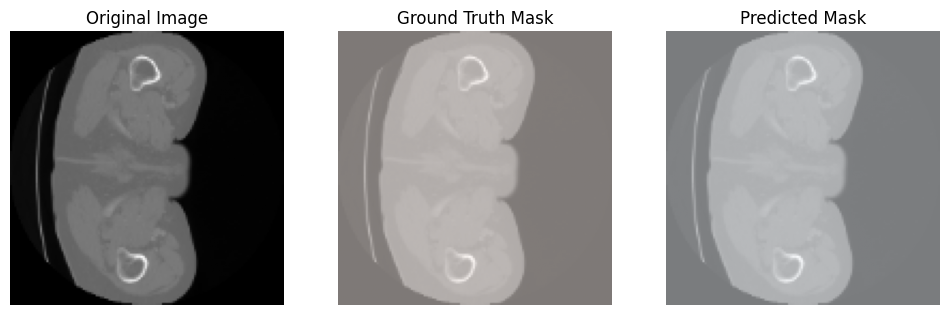

In [53]:
show_image_mask_pred(slice_idx=0, threshold=0.5)


In [54]:
def show_bw_image_mask_pred(slice_idx=0, threshold=0.5):
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')   # أبيض على أسود
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')  # prediction أبيض على أسود
    plt.axis('off')

    plt.show()


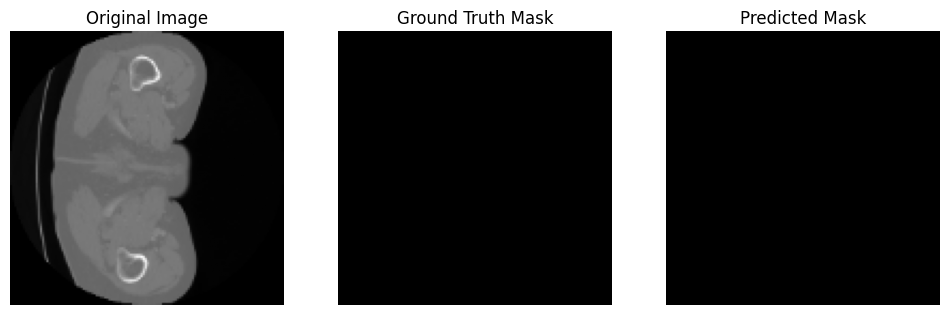

In [100]:
show_bw_image_mask_pred(slice_idx=0, threshold=0.5)


In [56]:
def show_bw_image_mask_pred(slice_idx=0, threshold=0.5):
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy() * 255  # من 0-1 لـ 0-255

    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32) * 255  # أبيض على أسود

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')   # أبيض على أسود
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')  # prediction أبيض على أسود
    plt.axis('off')

    plt.show()


In [57]:
def show_bw_image_mask_pred(slice_idx=0, threshold=0.5):
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.uint8) * 255  # 0 أو 255
        mask_disp = (mask > 0).astype(np.uint8) * 255          # 0 أو 255

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_disp, cmap='gray')   # أبيض على أسود
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')  # أبيض على أسود
    plt.axis('off')

    plt.show()


In [58]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_single_slice(slice_idx=0, threshold=0.5):
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.uint8) * 255  # أبيض على أسود
        mask_disp = (mask > 0).astype(np.uint8) * 255          # أبيض على أسود

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_disp, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.show()


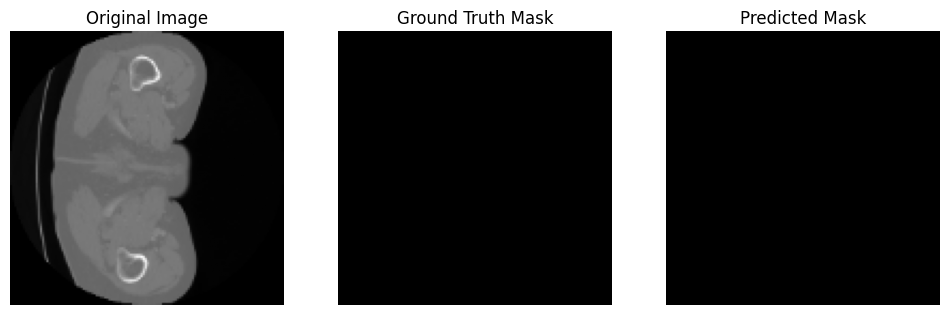

In [101]:
show_single_slice(slice_idx=0, threshold=0.5)



In [60]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_colored_slice(slice_idx=0, threshold=0.5):
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)  # 0 أو 1
        mask_disp = (mask > 0).astype(np.float32)        # 0 أو 1

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask_disp, cmap='Reds', alpha=0.5)   # mask أحمر نصف شفاف
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)   # prediction أزرق نصف شفاف
    plt.axis('off')

    plt.show()


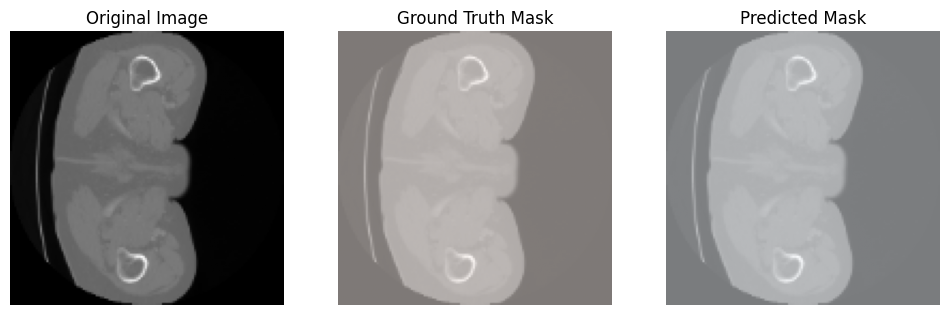

In [61]:
show_colored_slice(slice_idx=0, threshold=0.5)


In [62]:
import matplotlib.pyplot as plt
import torch
import numpy as np   # ← هنا كان الناقص

def show_colored_slice(slice_idx=0, threshold=0.5):
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = ((pred > threshold).astype(np.uint8)) * 255  # 0 أو 255
        mask_disp = ((mask > 0).astype(np.uint8)) * 255         # 0 أو 255

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(mask_disp, cmap='Reds', alpha=0.5)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(image, cmap='gray')
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)
    plt.axis('off')

    plt.show()


In [63]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_binary_slice(slice_idx=0, threshold=0.5):
    # تحميل صورة و ماسك
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.uint8)   # 0 أو 1
        mask_bin = (mask > 0).astype(np.uint8)           # 0 أو 1

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')   # أسود/أبيض فقط
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')   # أسود/أبيض فقط
    plt.axis('off')

    plt.show()


In [64]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_binary_slice(slice_idx=0, threshold=0.5):
    # تحميل صورة و ماسك
    image, mask = dataset[slice_idx]
    image = image[0].numpy()
    mask  = mask[0].numpy()

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()

        # تحويل للـ uint8 0-255
        pred_bin = ((pred > threshold).astype(np.uint8)) * 255
        mask_bin = ((mask > 0).astype(np.uint8)) * 255

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')   # أسود/أبيض
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')   # أسود/أبيض
    plt.axis('off')

    plt.show()


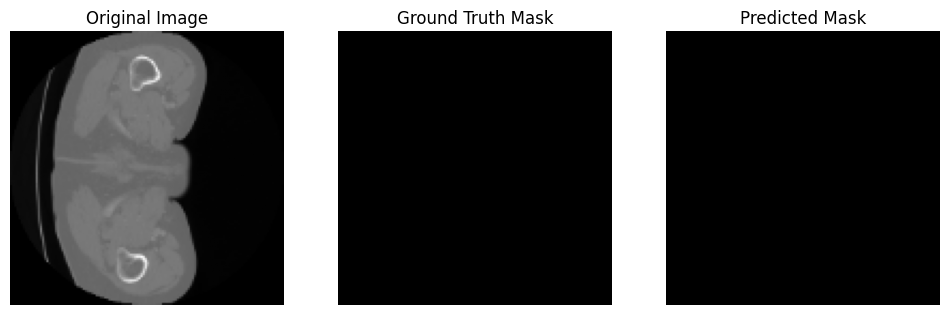

In [102]:
show_binary_slice(slice_idx=0, threshold=0.5)


In [66]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_binary_slice_safe(slice_idx=0, threshold=0.5):
    # الصورة والماسک
    image, mask = dataset[slice_idx]
    image = image[0].numpy().astype(np.float32)
    mask  = mask[0].numpy().astype(np.float32)

    # normalize الصورة للعرض
    if np.max(image) > 0:
        image = image / np.max(image)

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)
        mask_bin = (mask > 0).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.show()


In [67]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_first_nonzero_slice(threshold=0.5):
    # البحث عن أول slice فيه mask != 0
    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        mask = mask[0].numpy()
        if np.max(mask) > 0:   # فيه عضو
            slice_idx = idx
            break

    image, mask = dataset[slice_idx]
    image = image[0].numpy().astype(np.float32)
    mask  = mask[0].numpy().astype(np.float32)

    # normalize الصورة للعرض
    if np.max(image) > 0:
        image = image / np.max(image)

    # prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)
        mask_bin = (mask > 0).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.show()


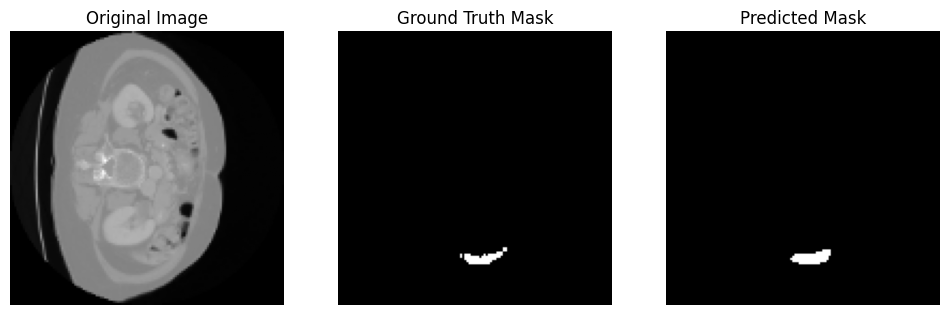

In [103]:
show_first_nonzero_slice(threshold=0.5)


In [70]:
!pip install segmentation-models-pytorch --quiet

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [72]:
# موديل LinkNet مع encoder مدرب مسبقًا على ImageNet
model = smp.Linknet(
    encoder_name="resnet34",       # اختاري encoder مناسب
    encoder_weights="imagenet",    # pretraining
    in_channels=1,                 # عدد قنوات الصورة (CT = 1)
    classes=1                       # عدد الـ masks (binary)
).to(device)


In [73]:
from torch.utils.data import DataLoader, random_split

# تقسيم dataset: 80% train و 20% val
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Train samples: 15683
Validation samples: 3921


In [74]:
# Loss
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [76]:
import numpy as np
import torch

# دوال التقييم
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(pred, target):
    pred = (pred > 0.5).astype(np.float32)
    return (pred == target).mean()

# التقييم على val_loader
model.eval()
dice_list = []
iou_list  = []
acc_list  = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)

        outputs = torch.sigmoid(model(images))
        outputs_np = outputs.cpu().numpy()
        masks_np   = masks.cpu().numpy()

        for i in range(outputs_np.shape[0]):
            pred_i = (outputs_np[i,0] > 0.5).astype(np.float32)
            mask_i = masks_np[i,0].astype(np.float32)

            dice_list.append(dice_coef(pred_i, mask_i))
            iou_list.append(iou_score(pred_i, mask_i))
            acc_list.append(accuracy(pred_i, mask_i))

print(f"Dice: {np.mean(dice_list):.4f}")
print(f"IoU:   {np.mean(iou_list):.4f}")
print(f"Accuracy: {np.mean(acc_list):.4f}")


Dice: 0.0762
IoU:   0.0455
Accuracy: 0.5708


In [78]:
import matplotlib.pyplot as plt

def show_slice(slice_idx=0, threshold=0.5):
    # أولًا نجيب slice من dataset
    image, mask = dataset[slice_idx]
    image = image[0].numpy().astype(np.float32)
    mask  = mask[0].numpy().astype(np.float32)

    # Normalize الصورة
    if np.max(image) > 0:
        image = image / np.max(image)

    # Prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)
        mask_bin = (mask > 0).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')
    plt.show()


In [79]:
def show_first_nonzero_slice(threshold=0.5):
    # البحث عن أول slice فيه mask != 0
    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        mask = mask[0].numpy()
        if np.max(mask) > 0:   # فيه عضو
            slice_idx = idx
            break

    image, mask = dataset[slice_idx]
    image = image[0].numpy().astype(np.float32)
    mask  = mask[0].numpy().astype(np.float32)

    # Normalize الصورة
    if np.max(image) > 0:
        image = image / np.max(image)

    # Prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)
        mask_bin = (mask > 0).astype(np.float32)

    # عرض
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.show()


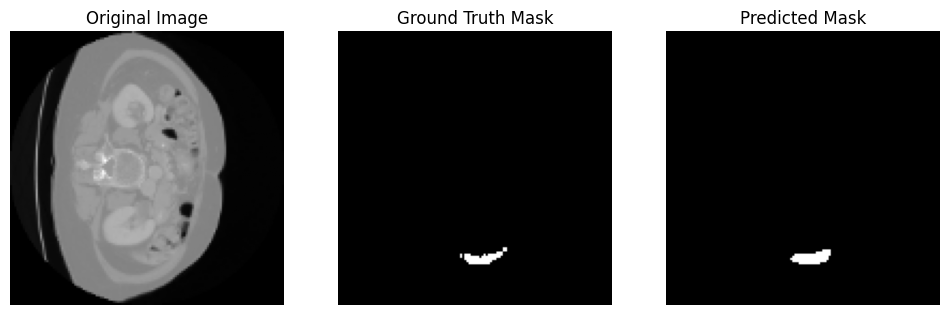

In [104]:
show_first_nonzero_slice(threshold=0.5)


In [81]:
import segmentation_models_pytorch as smp

# FCN مع encoder pre-trained
model = smp.FPN(  # مبدئيًا نستخدم FPN لأن smp مش فيه FCN محدد، FPN مشابه
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)


In [82]:
# Loss
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [83]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


KeyboardInterrupt: 

In [84]:
import numpy as np
import torch

# دوال التقييم
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(pred, target):
    pred = (pred > 0.5).astype(np.float32)
    return (pred == target).mean()

# التقييم على val_loader
model.eval()
dice_list = []
iou_list  = []
acc_list  = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)

        outputs = torch.sigmoid(model(images))
        outputs_np = outputs.cpu().numpy()
        masks_np   = masks.cpu().numpy()

        for i in range(outputs_np.shape[0]):
            pred_i = (outputs_np[i,0] > 0.5).astype(np.float32)
            mask_i = masks_np[i,0].astype(np.float32)

            dice_list.append(dice_coef(pred_i, mask_i))
            iou_list.append(iou_score(pred_i, mask_i))
            acc_list.append(accuracy(pred_i, mask_i))

print(f"Dice: {np.mean(dice_list):.4f}")
print(f"IoU:   {np.mean(iou_list):.4f}")
print(f"Accuracy: {np.mean(acc_list):.4f}")


Dice: 0.8148
IoU:   0.7831
Accuracy: 0.9903


In [85]:
import matplotlib.pyplot as plt

def show_first_nonzero_slice(threshold=0.5):
    # البحث عن أول slice فيه mask != 0
    for idx in range(len(dataset)):
        _, mask = dataset[idx]
        mask = mask[0].numpy()
        if np.max(mask) > 0:   # فيه عضو
            slice_idx = idx
            break

    image, mask = dataset[slice_idx]
    image = image[0].numpy().astype(np.float32)
    mask  = mask[0].numpy().astype(np.float32)

    # Normalize الصورة
    if np.max(image) > 0:
        image = image / np.max(image)

    # Prediction
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()
        pred_bin = (pred > threshold).astype(np.float32)
        mask_bin = (mask > 0).astype(np.float32)

    # عرض
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.show()


In [86]:
image = image[0].numpy().astype(np.float32)
if np.max(image) > 0:
    image = image / np.max(image)


In [87]:
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    pred = torch.sigmoid(model(input_tensor)).cpu()[0,0].numpy()


In [88]:
pred_bin = (pred > 0.2).astype(np.float32)



In [89]:
torch.save(model.state_dict(), "fcn_pretrained.pth")



In [90]:
# تعريف الموديل نفسه زي قبل كده
import segmentation_models_pytorch as smp

model = smp.FPN(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
).to(device)

# تحميل الأوزان السابقة
model.load_state_dict(torch.load("fcn_pretrained.pth"))


<All keys matched successfully>

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)



In [95]:
num_additional_epochs = 3  # مثلاً نزود 20 epoch

for epoch in range(num_additional_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_additional_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/3, Loss: 0.1041
Epoch 2/3, Loss: 0.0853
Epoch 3/3, Loss: 0.0790


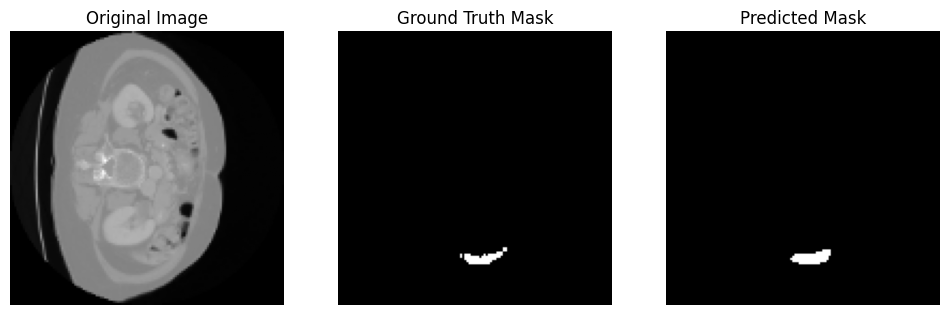

In [105]:
show_first_nonzero_slice(threshold=0.5)


In [97]:
import vtk
import numpy as np

def visualize_3d_mask(mask_np, spacing=(1.0, 1.0, 1.0), color=(1,0,0)):
    """
    mask_np: 3D numpy array, binary
    spacing: voxel spacing in mm
    color: RGB tuple (0-1)
    """

    # Convert numpy to VTK image
    data_importer = vtk.vtkImageImport()
    mask_string = mask_np.tostring()
    data_importer.CopyImportVoidPointer(mask_string, len(mask_string))
    data_importer.SetDataScalarTypeToUnsignedChar()
    data_importer.SetNumberOfScalarComponents(1)
    data_importer.SetDataExtent(0, mask_np.shape[2]-1,
                                0, mask_np.shape[1]-1,
                                0, mask_np.shape[0]-1)
    data_importer.SetWholeExtent(0, mask_np.shape[2]-1,
                                 0, mask_np.shape[1]-1,
                                 0, mask_np.shape[0]-1)
    data_importer.SetDataSpacing(spacing)

    # Marching cubes
    mc = vtk.vtkMarchingCubes()
    mc.SetInputConnection(data_importer.GetOutputPort())
    mc.SetValue(0, 0.5)  # iso-value between 0 and 1
    mc.Update()

    # Mapper & Actor
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(mc.GetOutputPort())
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(color)
    actor.GetProperty().SetOpacity(0.5)  # semi-transparent

    # Renderer
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0,0,0)

    # Render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800,800)

    # Interactor
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(render_window)
    interactor.Initialize()
    render_window.Render()
    interactor.Start()


In [98]:
import os
import torch

# نحدد المكان
if "kaggle" in os.getcwd():
    # شغالين جوه كاجل
    SAVE_DIR = "/kaggle/working/checkpoints"
else:
    # غالباً في كولاب
    SAVE_DIR = "/content/drive/MyDrive/heart_seg_project/checkpoints"

# نتأكد إن الفولدر موجود
os.makedirs(SAVE_DIR, exist_ok=True)

# مسار حفظ الموديل
MODEL_PATH = os.path.join(SAVE_DIR, "unet_best.pth")

# نحفظ الموديل
torch.save(model.state_dict(), MODEL_PATH)
print("✅ تم حفظ الموديل في:", MODEL_PATH)


✅ تم حفظ الموديل في: /content/drive/MyDrive/heart_seg_project/checkpoints/unet_best.pth


In [99]:
import os
import torch
import segmentation_models_pytorch as smp

# --------------------------
# 1. تحديد مكان الحفظ
# --------------------------
if "kaggle" in os.getcwd():
    # لو شغالين على كاجل
    SAVE_DIR = "/kaggle/working/checkpoints"
else:
    # لو شغالين على كولاب
    SAVE_DIR = "/content/drive/MyDrive/heart_seg_project/checkpoints"

os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, "unet_best.pth")


# --------------------------
# 2. حفظ الموديل
# --------------------------
def save_model(model, path=MODEL_PATH):
    torch.save(model.state_dict(), path)
    print("✅ تم حفظ الموديل في:", path)


# --------------------------
# 3. تحميل الموديل
# --------------------------
def load_model(path=MODEL_PATH, n_classes=4, in_channels=1, device="cuda"):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,  # علشان هنحمل الأوزان بتاعتنا
        in_channels=in_channels,
        classes=n_classes
    )
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print("✅ تم تحميل الموديل من:", path)
    return model
